#Interpretable Machine Learning

---






# Introduction
Currently there are a lot of implementations of the most suitable learning algorithms ranging from classical regression  as linear and logistic regression to robust algorithms as Random Forest, Multilayer Perceptron Networks, Recurrent Neural Networks among others. Typically, such implementations allow us to **build quickly models about our problems** but they hide important details becomining dark components that prevent the interpretation and why of their predictions. Meaning by interpretability, the ability to comprehend how the model achieve its prediction , in these regard, we cited two  important authors:
1. *“Interpretability is the degree to which a human can understand the cause of a decision.”* — **Tim Miller**
2. *“Interpretability is the degree to which a human can consistently predict the model’s result.”* — **Been Kim**




# Businnes Context

Regardless of the machine learning algorithms used to get such a model, most of them involve an important complexity degree which become them *Black Boxes*. As Data Scientists it is compulsory to decipher the "*enigma*" of these boxes in order to improve our model and explain the way in which it achieves a prediction.

# Business Problem
In this Section, you will build two models: 1) one based on structured data from which you will attempt to explain its behavior and 2) one based on textual data. For this you will use several tool based on State-of-Art methods.

# Analytical Context

1. We will show you how to predict propensity of customer prospects. We will use web clicks data about the links clicked by the user while he is browsing to design a prediction model about his propensity to buy the product. Using that propensity, we can made decision as whether offering chat to the customer with an agent. Based on this problem, we will interpret the model via **ELI5**.

2. We will show how to predict the category of a text corresponding to an email. For this, we will illustrate a classical pipeline of Text Mining.


# Structured-Data Model

**Libraries and functions for the model**

In [1]:
###################################################
#Libraries
###################################################
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

In [2]:
#nativos
import os
import gc
import json
import unicodedata
import random as rn
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### SEMILLAS
SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [3]:
######################################################
#Functions
#######################################################
def plot_prediction(prediction, labels):
    levels = np.arange(len(labels))
    
    # Create bars
    plt.bar(levels, propensity, color=['firebrick', 'green'] )
    # Create names on the x-axis
    plt.xticks(levels, labels)
    # Show graphic
    plt.show()

**Loading dataset**

In [4]:
#from google.colab import files
#uploaded = files.upload()
#import io
#prospect_data = pd.read_csv(io.BytesIO(uploaded['browsing.csv']), header=0, encoding="utf-8",sep=",")

prospect_data = pd.read_csv(
    'data/browsing.csv', 
    header=0, 
    encoding="utf-8",
    sep=","
)

print(prospect_data.shape)
prospect_data.head()

(500, 12)


,SESSION_ID,IMAGES,REVIEWS,FAQ,SPECS,SHIPPING,BOUGHT_TOGETHER,COMPARE_SIMILAR,VIEW_SIMILAR,WARRANTY,SPONSORED_LINKS,BUY
0,1001,0,0,1,0,1,0,0,0,1,0,0
1,1002,0,1,1,0,0,0,0,0,0,1,0
2,1003,1,0,1,1,1,0,0,0,1,0,0
3,1004,1,0,0,0,1,1,1,0,0,0,0
4,1005,1,1,1,0,1,0,1,0,0,0,0


**Exploring Data**

The data contains information about the various links on the website that are clicked by the user during his browsing. This is past data that will be used to build the model.

1. Session ID : A unique identifier for the web browsing session
2. Buy : Whether the prospect ended up buying the product
3. Other columns : a 0 or 1 indicator to show whether the prospect visited that particular page or did the activity mentioned.

In [5]:
prospect_data.head()

,SESSION_ID,IMAGES,REVIEWS,FAQ,SPECS,SHIPPING,BOUGHT_TOGETHER,COMPARE_SIMILAR,VIEW_SIMILAR,WARRANTY,SPONSORED_LINKS,BUY
0,1001,0,0,1,0,1,0,0,0,1,0,0
1,1002,0,1,1,0,0,0,0,0,0,1,0
2,1003,1,0,1,1,1,0,0,0,1,0,0
3,1004,1,0,0,0,1,1,1,0,0,0,0
4,1005,1,1,1,0,1,0,1,0,0,0,0


**Feature Selection**

As first approach to the feature selection, we can determine the relationships between the variables of the dataset. 

<AxesSubplot:>

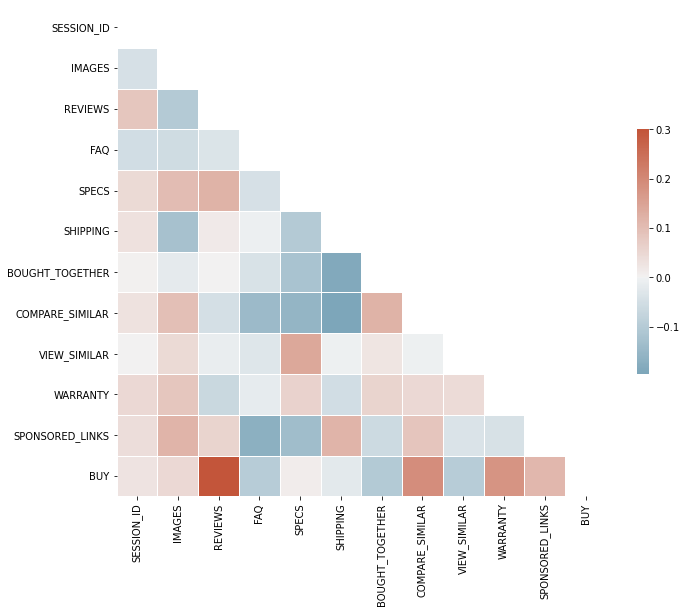

In [6]:
correlation_matrix=prospect_data.corr(method="pearson") 

#Use only predictor variables
# Generate a mask for the upper triangle
mask = np.triu(
    np.ones_like(correlation_matrix, dtype=bool)
)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(
    230, 20, as_cmap=True
)

sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)

In [7]:
correlation_matrix['BUY'].abs().sort_values(ascending=False)

BUY                1.000000
REVIEWS            0.404628
COMPARE_SIMILAR    0.190522
WARRANTY           0.179156
SPONSORED_LINKS    0.110328
BOUGHT_TOGETHER    0.103562
VIEW_SIMILAR       0.096137
FAQ                0.095136
IMAGES             0.046819
SESSION_ID         0.026677
SHIPPING           0.022239
SPECS              0.009950
Name: BUY, dtype: float64

In [8]:
#Determine predictors and outcome 
predictors = prospect_data[['REVIEWS','BOUGHT_TOGETHER','COMPARE_SIMILAR','WARRANTY','SPONSORED_LINKS']]
targets = prospect_data.BUY

# The model

**Building a Model**

In [9]:
#Split the dataset into training and test datasets
pred_train, pred_test, tar_train, tar_test  =   train_test_split(predictors, targets, test_size=.3)
print( "Predictor - Training : ", pred_train.shape, "Predictor - Testing : ", pred_test.shape )

#from sklearn.svm import SVC
#classifier=SVC(probability=True, kernel='linear')
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(random_state=SEED)
classifier=classifier.fit(pred_train,tar_train)

Predictor - Training :  (350, 5) Predictor - Testing :  (150, 5)


**Evaluating the model**

In [10]:
#Analyze accuracy of predictions
predictions=classifier.predict(pred_test)
#Analyze accuracy of predictions
sklearn.metrics.confusion_matrix(tar_test,predictions)

array([[74, 15],
       [13, 48]], dtype=int64)

In [11]:
sklearn.metrics.accuracy_score(tar_test, predictions)

0.8133333333333334

In [12]:
sklearn.metrics.roc_auc_score(tar_test, predictions)

0.8091729600294714

**Use probability as criterion of prediction**

Instead of doing a Yes/No prediction, we can instead do a probability computation to show the probability for the prospect to buy the product

In [13]:
pred_prob = classifier.predict_proba(pred_test)
print(pred_prob[0,0])
print(pred_prob[0,1])

0.4198240145577701
0.5801759854422299


# Realtime Predictions
Now that the model has been built, let us use it for real time predictions. So when the customer starts visiting the pages one by one, we collect that list and then use it to compute the probability. We do that for every new click that comes in. So let us start. The prospect just came to your website. There are no significant clicks. Let us compute the probability. The array of values passed has the values for REVIEWS, BOUGHT_TOGETHER, COMPARE_SIMILAR, WARRANTY and SPONSORED_LINKS. So the array is all zeros to begin with


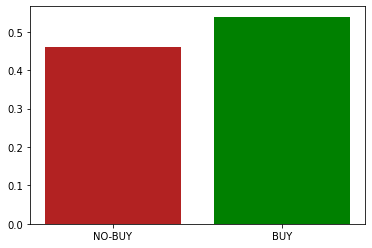

New visitor: propensity : [0.53921947]


In [14]:
#Recall the name of the variables:REVIEWS, BOUGHT_TOGETHER, COMPARE_SIMILAR, WARRANTY and SPONSORED_LINKS
browsing_data = np.array([1,1,1,1,1]).reshape(1, -1) #Potential Customer
prediction=classifier.predict_proba(browsing_data)
propensity = prediction[0,:]
plot_prediction(prediction, ('NO-BUY','BUY'))
print("New visitor: propensity :",classifier.predict_proba(browsing_data)[:,1] )

# Interpretability of the Model

**Eli5**

[ELI5](https://eli5.readthedocs.io/en/latest/index.html) is a visualization library that is useful for debugging machine learning models and **explaining** the predictions they have produced. ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions. It provides support for the following machine learning frameworks and packages:

1. scikit-learn. Currently ELI5 allows to explain weights and predictions of scikit-learn linear classifiers and regressors, print decision trees as text or as SVG, show feature importances and explain predictions of decision trees and tree-based ensembles.

2. ELI5 understands text processing utilities from scikit-learn and can highlight text data accordingly. It also allows to debug scikit-learn pipelines which contain HashingVectorizer, by undoing hashing.

3. Keras - explain predictions of image classifiers via Grad-CAM visualizations.

4. XGBoost - show feature importances and explain predictions of XGBClassifier, XGBRegressor and xgboost.Booster.


ELI5 is based on:
1. [Permutation Importance:](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html#eli5-permutation-importance) For any black-box estimator by measuring **how score decreases when a feature is not available**; this score is also known as  “Mean Decrease Accuracy (MDA)"
2. [LIME (Local Interpretable Model-agnostic Explanations):](https://eli5.readthedocs.io/en/latest/blackbox/lime.html) In Figure, we show an intuitive diagram.

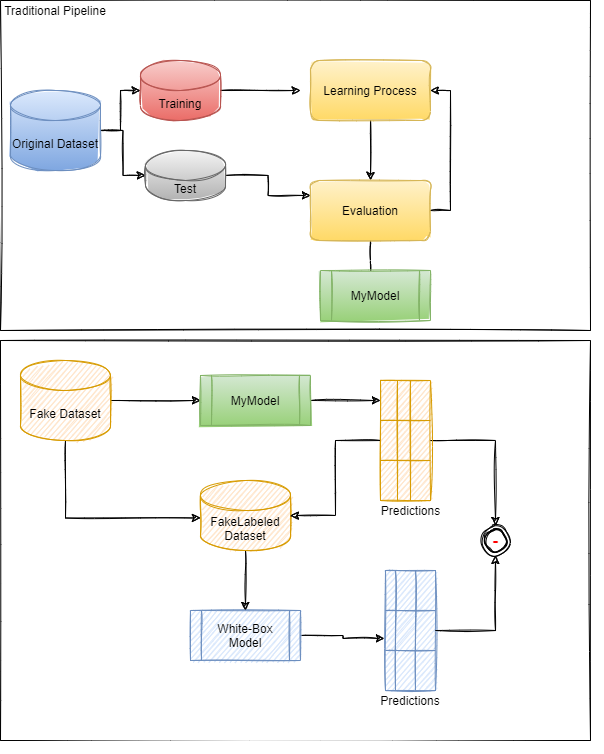


In [15]:
!pip install eli5

In [16]:
#Using permutation importance
import eli5
from IPython.display import display

display(
    eli5.show_weights(classifier, top=10, feature_names = predictors.columns.tolist(), show_feature_values=True)
)

Weight,Feature
0.3381 ± 0.1506,REVIEWS
0.1872 ± 0.2084,WARRANTY
0.1733 ± 0.2287,BOUGHT_TOGETHER
0.1634 ± 0.1861,COMPARE_SIMILAR
0.1380 ± 0.1220,SPONSORED_LINKS


In [17]:
#The function show_prediction use LIME
import random
rand = random.randint(1, len(pred_test))
to_predict = pred_test.iloc[rand,:]
print(to_predict)

REVIEWS            0
BOUGHT_TOGETHER    0
COMPARE_SIMILAR    0
WARRANTY           1
SPONSORED_LINKS    0
Name: 118, dtype: int64


In [18]:
eli5.show_prediction(
    classifier,
    to_predict, 
    feature_names=predictors.columns.tolist(), 
    show_feature_values=True
)

**Another implementation of LIME** 

LIME is a package for explaining the predictions made by machine learning algorithms. Lime supports explanations for individual predictions from a wide range of classifiers, and support for **scikit-learn** is built in.

In [19]:
pip install lime

In [20]:
rand

59

In [21]:
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(pred_train.values,                                            
                 feature_names=pred_train.columns.values.tolist(),                                        
                 class_names=tar_train.unique())

In [22]:
predict_fn = lambda x: classifier.predict_proba(x).astype(float)

In [23]:
print(pred_train.columns)
print(pred_test.values[rand])
exp = explainer.explain_instance(pred_test.values[rand], predict_fn, num_features=6)
exp.show_in_notebook(show_all=False)

Index(['REVIEWS', 'BOUGHT_TOGETHER', 'COMPARE_SIMILAR', 'WARRANTY',
       'SPONSORED_LINKS'],
      dtype='object')
[0 0 0 1 0]


Why do the explainers differ between their explanations?

**Answer:**

**SHAP (SHapley Additive exPlanations )**

SHAP is a novel approach to XAI developed by Scott Lundberg at Microsoft and eventually opened sourced. SHAP is based on a strong mathematical foundation using the classic Shapley values from game theory and their related extensions (see [paper](https://github.com/slundberg/shap#citations))

In [24]:
!pip install shap

In [25]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(pred_train)

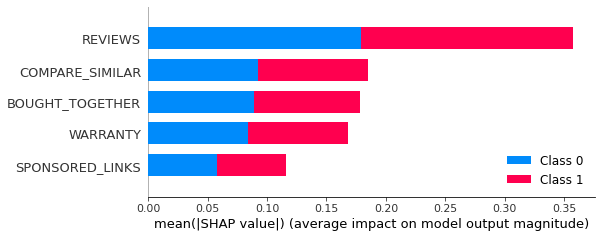

In [26]:
shap.summary_plot(shap_values, pred_train, plot_type="bar")

# Explaining a Natural Language Processing Model

## Loading corpus

In [27]:
import numpy as np
import pandas as pd
#from google.colab import files
#uploaded = files.upload()

import io
dataset = pd.read_csv('data/spam2.csv', encoding="ISO-8859-1")
dataset.head()


,class,class_ name,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,0,ham,Ok lar... Joking wif u oni...
2,1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,ham,U dun say so early hor... U c already then say...
4,0,ham,"Nah I don't think he goes to usf, he lives aro..."


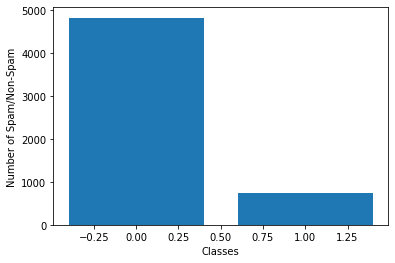

In [28]:
#View cardinality of  classes
spam_count=dataset.groupby('class').count()
from matplotlib import pyplot as plt
plt.bar(spam_count.index.values, spam_count['text'])
plt.xlabel('Classes')
plt.ylabel('Number of Spam/Non-Spam')
plt.show()

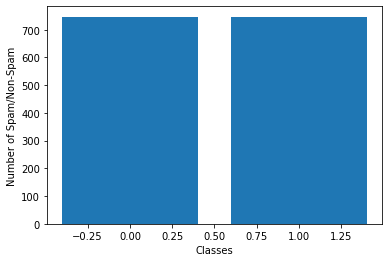

In [29]:
#Balancing classes
size_minor_class=747
imbalanced_class=dataset.loc[dataset['class']==0]
imbalanced_class=imbalanced_class.sample(n=size_minor_class, random_state=1)
balanced_class=dataset.loc[dataset['class']==1]

#New dataset
dataset = pd.concat([imbalanced_class,balanced_class])
spam_count=dataset.groupby('class').count()
from matplotlib import pyplot as plt
plt.bar(spam_count.index.values, spam_count['text'])
plt.xlabel('Classes')
plt.ylabel('Number of Spam/Non-Spam')
plt.show()

## Preprocessing

In [30]:
#Lowercase
dataset['text'] = dataset['text'].str.lower()
dataset.head()

,class,class_ name,text
2535,0,ham,can you pls pls send me a mail on all you know...
1213,0,ham,"yeah, probably but not sure. ilol let u know, ..."
522,0,ham,were gonna go get some tacos
5398,0,ham,hi. hope you had a good day. have a better night.
700,0,ham,how much r ?_ willing to pay?


In [31]:
#Tokenizing
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import nltk
nltk.download('punkt')
#Option 1:
dataset['tokenized_text'] = dataset['text'].apply(word_tokenize) 
dataset.tail()

tokenizer = RegexpTokenizer("[a-zA-Z]{3,}")
dataset['tokenized_text'] = dataset['text'].map(tokenizer.tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Villacorta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
#Remove stop words (sometimes it is no convenient to remove them)
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')
dataset['without_stop_words'] =dataset['tokenized_text'].apply(lambda x: [item for item in x if item not in stop])
dataset.tail()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Villacorta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,class,class_ name,text,tokenized_text,without_stop_words
5537,1,spam,want explicit sex in 30 secs? ring 02073162414...,"[want, explicit, sex, secs, ring, now, costs, ...","[want, explicit, sex, secs, ring, costs, min, ..."
5540,1,spam,asked 3mobile if 0870 chatlines inclu in free ...,"[asked, mobile, chatlines, inclu, free, mins, ...","[asked, mobile, chatlines, inclu, free, mins, ..."
5547,1,spam,had your contract mobile 11 mnths? latest moto...,"[had, your, contract, mobile, mnths, latest, m...","[contract, mobile, mnths, latest, motorola, no..."
5566,1,spam,reminder from o2: to get 2.50 pounds free call...,"[reminder, from, get, pounds, free, call, cred...","[reminder, get, pounds, free, call, credit, de..."
5567,1,spam,this is the 2nd time we have tried 2 contact u...,"[this, the, time, have, tried, contact, have, ...","[time, tried, contact, pound, prize, claim, ea..."


## Feature Extraction

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy_fun(doc):
    return doc

cv = CountVectorizer(
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)
  
tdm = cv.fit_transform(dataset['without_stop_words'])
print("Number of documents:"+str(tdm.shape[0]))
print("Number of unique words (Vocabulary):"+str(tdm.shape[1]))
print("Contain of TDM for the document 1 and the top 100 words")
tdm[1,1:100].toarray()

Number of documents:1494
Number of unique words (Vocabulary):3394
Contain of TDM for the document 1 and the top 100 words


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [40]:
tdm

<1494x3394 sparse matrix of type '<class 'numpy.int64'>'
	with 14416 stored elements in Compressed Sparse Row format>

At this point, out dataset has become a matrix containing frecuencies of the words.

## Building the model

In [36]:
#Training a test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tdm, dataset['class'], test_size=0.3, random_state=1)

import nltk.classify.util
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

## Evaluation



In [37]:
print("Test  Accuracy : %.2f"%dt.score(X_test, y_test))
print("Train Accuracy : %.2f"%dt.score(X_train, y_train))

print("Confusion Matrix : ")
print(confusion_matrix(y_test, dt.predict(X_test)))
print()

Test  Accuracy : 0.91
Train Accuracy : 1.00

Confusion Matrix : 
[[205  17]
 [ 24 203]]



## Interpretability

In [38]:
import eli5
eli5.show_weights(dt, vec=cv, targets=[0,1], target_names=["ham", "spam"], top=15)

Weight,Feature
0.2214,call
0.1589,txt
0.0894,free
0.0762,www
0.0418,text
0.0317,send
0.0207,order
0.0165,later
0.0160,chat
0.0157,http


In [39]:
to_predict=np.array(dataset.without_stop_words)[1005]
print(to_predict)

eli5.show_prediction(dt, to_predict, vec=cv, top=100)

['free', 'nokia', 'motorola', 'upto', 'mths', 'price', 'linerental', 'free', 'net', 'mins', 'txt', 'mth', 'free', 'tooth', 'call', 'mobileupd', 'call', 'optout']
